In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as scs
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import pmdarima as pm

## Обучение моделей

функция выводит метрики для сравнения моделей

In [2]:
def metrics(real, forecast): #функция вывода метрик
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values

    forecast=np.array(forecast)
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))

функция обучает модели из класса тройного экспоненциального сглаживания и строит графики
- df - таблица данных, 
- train_dur - дата, которой заканчивается обучающая выборка,  
- trend - аддитивный или экспоненциальный тренд, 
- season - аддитивный или мультипликативная сезонность, 
- period - сколько периодов в сезоне, 
- damped - изменил ли тренд направление, - title - заголовок графика

In [3]:
def model(df, train_dur, trend, season, period, damped, title):    
    train_dur=train_dur
    train, test = df[:train_dur], df[train_dur:]
    fitted_model = ExponentialSmoothing(train['qty'],trend=trend,seasonal=season, #обучаем модель
                                        seasonal_periods=period, damped_trend=damped,initialization_method="estimated", ).fit()   
    predictions = fitted_model.forecast(len(test))
    test_predictions=pd.DataFrame(predictions)
    test_predictions=test_predictions.rename(columns={0:'qty'})
    
    t_crit=scs.t.ppf(1-(0.05/2), len(test)) #t критерий стьюдента 2хстороний
    err=np.sqrt((np.sum((test_predictions - test)**2))/len(test))
    up=test_predictions+err*t_crit
    down=test_predictions-err*t_crit
    
    #строим график
    train['qty'].plot(legend=True, label='ОБУЧАЮЩАЯ ВЫБОРКА',figsize=(17,5), color='black')
    test['qty'].plot(legend=True,label='ТЕСТОВАЯ ВЫБОРКА', color='orange')
    fitted_model.fittedvalues.plot(legend=True,label='ОБУЧЕННАЯ МОДЕЛЬ', color='blue', linewidth=0.8)
    test_predictions['qty'].plot(legend=True,label='ПРОГНОЗ', color='g')
    up['qty'].plot(color='r', legend=True, label='ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ',linewidth=0.8, linestyle='--')
    down['qty'].plot( color='r', linewidth=0.8, linestyle='--')
    plt.fill_between(test_predictions.index, up['qty'], down['qty'], 
                     color='lightgrey', alpha=.1)
    plt.title(title, size=14)
    plt.ylabel('Количество, кейсы', size=14)
    plt.xlabel('Дата', size=14)
    plt.grid(axis='y', linestyle =':')
    plt.show()
    None
    
    #выводим метрики
    display(fitted_model.params)
    display(metrics(train, fitted_model.fittedvalues))
    display(metrics(test, predictions))

функция обучает модель в соответствии с указанными параметрами (которые можно определить с помощью функции sarima_detect) и строит график

In [4]:
def sarima(df, p, d, q, P, D, Q, S, train_dur, file_name):    
    df=df.fillna(0)
    train, test = df[:train_dur], df[train_dur:]

    mod=sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S)) 
    results=mod.fit()

    print(results.summary().tables[1])

    print('Обучающая выборка')
    display(metrics(train, results.fittedvalues))
    print('Тестовая выборка')
    display(metrics(test, results.forecast(len(test))))
    
    #график саримы
    predict=results.get_prediction(start='2021-01-01', end='2021-12-31')
    df['qty'].plot(label='ФАКТ', color='black', figsize=(17,4))
    results.fittedvalues.plot(color='red', label='ОБУЧЕННАЯ МОДЕЛЬ')
    predict.predicted_mean.plot(color='green', label='ПРОГНОЗ',linewidth=2)
    plt.title(f"Модель SARIMA {p, d, q, P, D, Q, S} для {file_name}", size=14)
    plt.ylabel('Количество, кейсы', size=14)
    plt.xlabel('Дата', size=14)
    plt.grid(axis='y', linestyle =':')
    plt.legend()
    plt.show()

суммарная функция, которая чистит данные от аномалий и агругирует в себе все вышеописанные функции в необходимом порядке. чтобы обучить все модели и вывести необходимые графики обращайся к этой функции.

- file_name - название файла с данными без расширения (по умолчанию .xlsx), 
- date_cut - дата с которой берем временной ряд, можно отрезать начало если поведение отличается, 
- annomaly_share - % вероятности появления объема, начиная которого данные будут считаться аномалиями и заменены на скользящую среднюю, 
- window - окно скользящей средней для определения аномалий, 
- damped - менялся ли тренд,
- p,d,q,P,D,Q,S - параметры SARIMA.

In [5]:
def total_models(file_name, date_cut, annomaly_share, window, damped, p,d,q,P,D,Q,S):
    
    df = pd.read_excel(file_name+'.xlsx', parse_dates=['date'])
    df=df[df['date']>=date_cut]
    df=df.set_index('date')
    df=df.resample('W').sum()
    df=df.dropna()
    
    #график продаж до чистки
    plt.figure(figsize=(17,4))

    plt.plot(df, linewidth=2, color='black')
    plt.ylabel('Количество, кейсы', size=14)
    plt.xlabel('Дата', size=14)
    plt.title(f'Продажи {file_name} за 2018-2021 гг., неочищенные', size=14)
    plt.show()

#-------------------------------------------------------------------------------------------------------
    # убираем аномалии которые превосходят допустимый % вероятности, заменяя на скользящее среднее с окном = window
    rolling_mean = df['qty'].rolling(window=window).mean()

    t_crit=scs.t.ppf(1-annomaly_share, df.shape[0]) #t критерий стьюдента 
    rolling_std =  df['qty'].rolling(window=window).std()
    upper_bond = rolling_mean+t_crit*rolling_std
    lower_bond = rolling_mean-t_crit*rolling_std

    df['up']=upper_bond
    df['low']=lower_bond
    df['rolling']=rolling_mean

    df.loc[(df['qty']>df['up'])|(df['qty']<df['low'])|(df['qty']<=5), 'qty']=df['rolling']
    df=df.drop(columns=['up','low', 'rolling'], axis=1)
    
    #график продаж после очистки от выбросов
    plt.figure(figsize=(17,4))

    plt.plot(df, linewidth=2, color='black')
    plt.ylabel('Количество, кейсы', size=14)
    plt.xlabel('Дата', size=14)
    plt.title(f'Продажи {file_name} за 2018-2021 гг., очищенные от промо', size=14)
    plt.show()
    
#-----------------------------------------------------------------------------------------------------------    
    # применяем модели
    
    model(df, '2021-01-01', 'add', 'add', S, damped, f'Модель Тейла-Вейджа для {file_name} ')
    model(df, '2021-01-01', 'mul', 'add', S, damped, f'Модель Тейла-Вейджа c экспоненциальным трендом для {file_name}')
    model(df, '2021-01-01', 'add', 'mul', S, damped, f'Модель Хольта-Уинтерса для {file_name}')
    model(df, '2021-01-01', 'mul', 'mul', S, damped, f'Модель Уинтерса с экспоненциальным трендом для {file_name}')
    
    print('')
    print('--------------------------------SARIMA MODEL-----------------------------')
    sarima(df, p, d, q, P, D, Q, S, '2021-01-01', file_name)
    print('')
    print('')

вызываем функцию total_models и получаем обученные модели

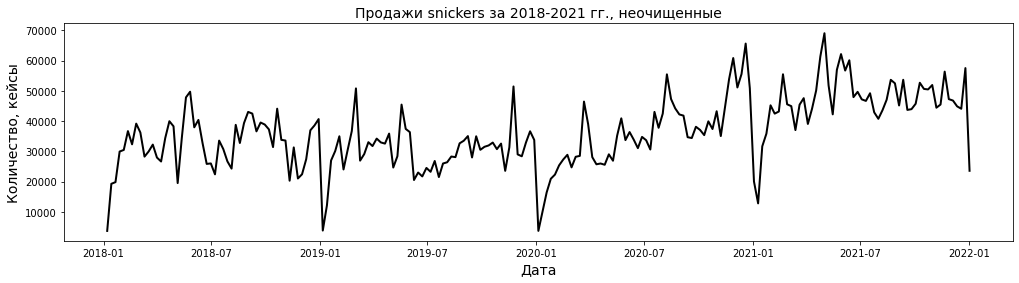

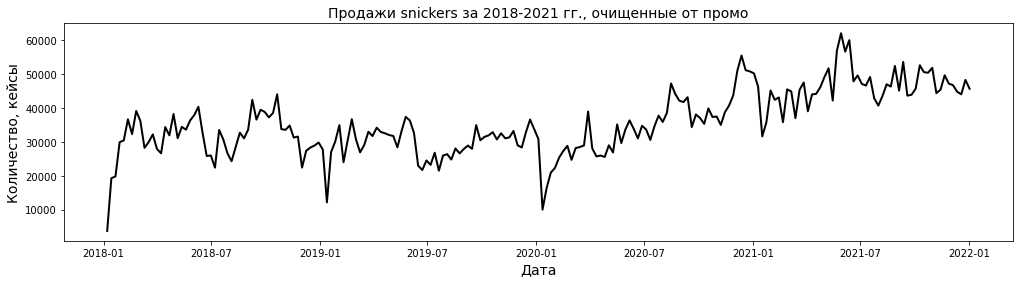

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


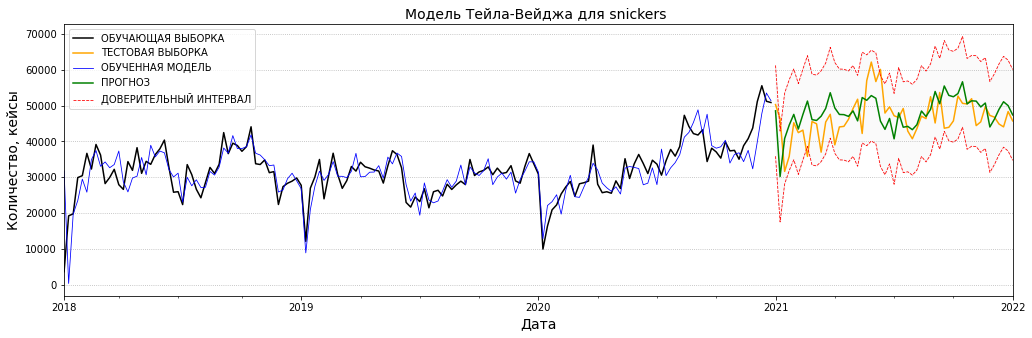

{'smoothing_level': 0.46464285714285714,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.00010000000000000002,
 'damping_trend': nan,
 'initial_level': 31948.22485067159,
 'initial_trend': -23.910245393144805,
 'initial_seasons': array([  -158.14412545, -18460.73046706,  -7831.10742275,  -4084.67595116,
         -1066.04975956,  -5133.52654705,  -1055.09718187,   2717.24915468,
         -2435.29261177,  -2651.4186811 ,  -1441.37237849,    742.74504273,
          5151.99904769,    929.75127215,   -866.24141167,   -897.33451333,
         -1356.43710596,    190.04594241,  -2571.87978092,   3956.56040931,
          3210.6663774 ,   4550.29367282,   3816.1097468 ,  -2513.93356007,
         -4802.83665915,  -1742.63134078,  -7406.18298701,   -128.1349723 ,
         -4120.74653288,  -3864.51418422,  -4765.95195384,  -3344.20169538,
           485.55038132,  -1019.51879244,   1016.89989734,   6002.85472546,
          2597.37040026,   7581.64857695,   4977.3681722 ,   4615.57201778,
      

MSE: 20587902.4997
MAPE: 0.1435
MPE: -0.0407


None

MSE: 39876745.6752
MAPE: 0.1085
MPE: -0.0443


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


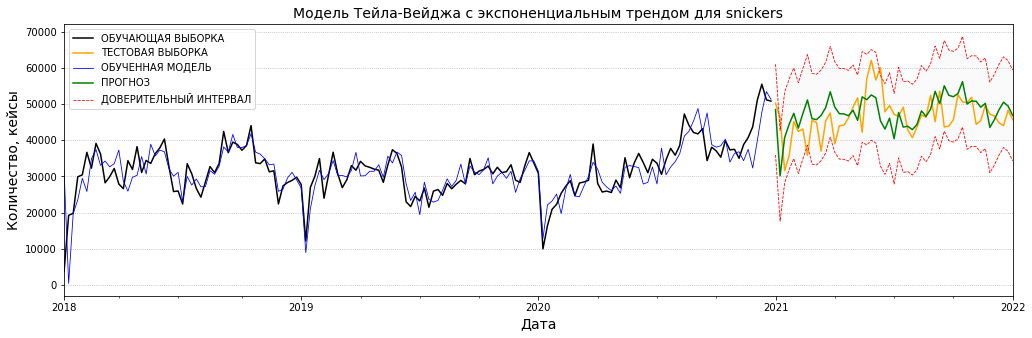

{'smoothing_level': 0.46464285714285714,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.00010000000000000002,
 'damping_trend': nan,
 'initial_level': 31948.22485067159,
 'initial_trend': 0.9992515939303388,
 'initial_seasons': array([  -158.14412545, -18460.73046706,  -7831.10742275,  -4084.67595116,
         -1066.04975956,  -5133.52654705,  -1055.09718187,   2717.24915468,
         -2435.29261177,  -2651.4186811 ,  -1441.37237849,    742.74504273,
          5151.99904769,    929.75127215,   -866.24141167,   -897.33451333,
         -1356.43710596,    190.04594241,  -2571.87978092,   3956.56040931,
          3210.6663774 ,   4550.29367282,   3816.1097468 ,  -2513.93356007,
         -4802.83665915,  -1742.63134078,  -7406.18298701,   -128.1349723 ,
         -4120.74653288,  -3864.51418422,  -4765.95195384,  -3344.20169538,
           485.55038132,  -1019.51879244,   1016.89989734,   6002.85472546,
          2597.37040026,   7581.64857695,   4977.3681722 ,   4615.57201778,
       

MSE: 20577487.0048
MAPE: 0.1435
MPE: -0.0408


None

MSE: 39127969.1564
MAPE: 0.1064
MPE: -0.0386


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


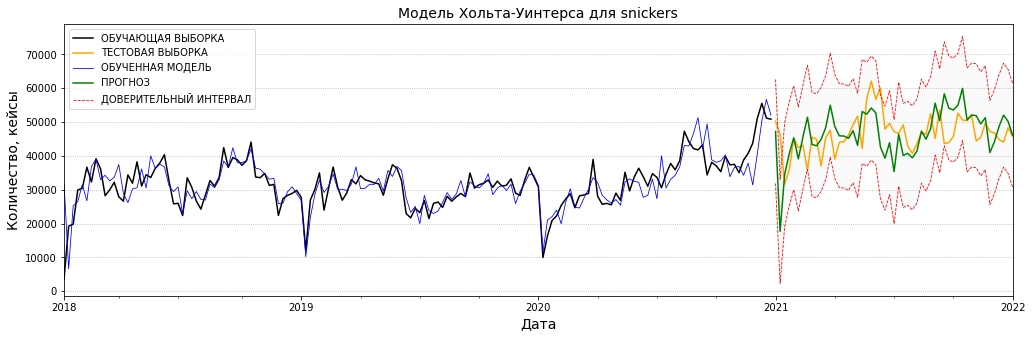

{'smoothing_level': 0.5,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.0001,
 'damping_trend': nan,
 'initial_level': 31948.22485067159,
 'initial_trend': -23.910245393144805,
 'initial_seasons': array([0.99697342, 0.37313958, 0.72932457, 0.85793264, 0.95933018,
        0.82757833, 0.96356043, 1.08938453, 0.91910216, 0.91147726,
        0.95227796, 1.02614671, 1.16747869, 1.03434756, 0.97601559,
        0.97536641, 0.96087662, 1.00988619, 0.91757078, 1.13142587,
        1.11505237, 1.15459681, 1.12429716, 0.91096456, 0.83946044,
        0.93759015, 0.75553245, 0.99252188, 0.85864635, 0.87233662,
        0.84433537, 0.88684343, 1.01396409, 0.9636318 , 1.03101961,
        1.19315221, 1.08213867, 1.25371994, 1.16256325, 1.15216952,
        1.18225286, 1.29055468, 1.09042876, 1.12240961, 1.11809575,
        1.06664148, 1.1065936 , 0.88428344, 0.95415206, 1.05054232,
        1.12501235, 1.08530092]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

MSE: 19630776.5877
MAPE: 0.1396
MPE: -0.0491


None

MSE: 58750900.8005
MAPE: 0.1212
MPE: -0.013


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


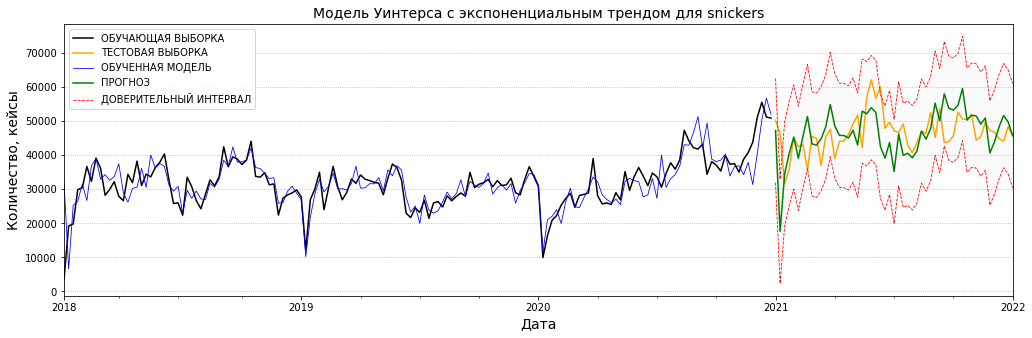

{'smoothing_level': 0.5,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.0001,
 'damping_trend': nan,
 'initial_level': 31948.22485067159,
 'initial_trend': 0.9992515939303388,
 'initial_seasons': array([0.99697342, 0.37313958, 0.72932457, 0.85793264, 0.95933018,
        0.82757833, 0.96356043, 1.08938453, 0.91910216, 0.91147726,
        0.95227796, 1.02614671, 1.16747869, 1.03434756, 0.97601559,
        0.97536641, 0.96087662, 1.00988619, 0.91757078, 1.13142587,
        1.11505237, 1.15459681, 1.12429716, 0.91096456, 0.83946044,
        0.93759015, 0.75553245, 0.99252188, 0.85864635, 0.87233662,
        0.84433537, 0.88684343, 1.01396409, 0.9636318 , 1.03101961,
        1.19315221, 1.08213867, 1.25371994, 1.16256325, 1.15216952,
        1.18225286, 1.29055468, 1.09042876, 1.12240961, 1.11809575,
        1.06664148, 1.1065936 , 0.88428344, 0.95415206, 1.05054232,
        1.12501235, 1.08530092]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

MSE: 19621282.81
MAPE: 0.1395
MPE: -0.0492


None

MSE: 58189433.0667
MAPE: 0.1203
MPE: -0.0083


None


--------------------------------SARIMA MODEL-----------------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6793      0.106      6.386      0.000       0.471       0.888
ma.L1         -0.8882      0.080    -11.163      0.000      -1.044      -0.732
sigma2      2.177e+07   2.24e-09   9.71e+15      0.000    2.18e+07    2.18e+07
Обучающая выборка
MSE: 24060214.3326
MAPE: 0.1338
MPE: 0.0056


None

Тестовая выборка
MSE: 33705085.519
MAPE: 0.0883
MPE: 0.0038


None

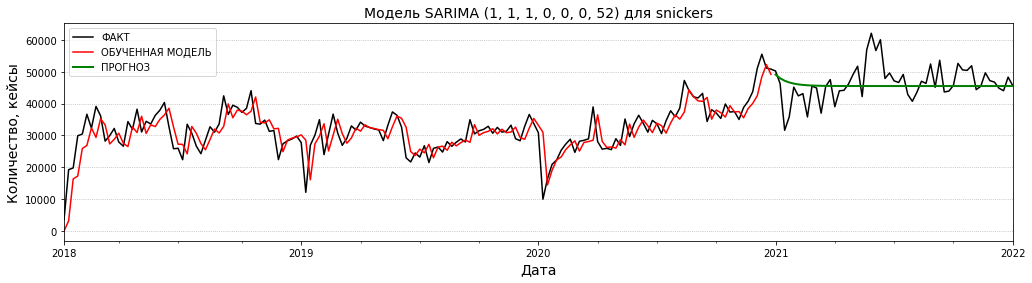

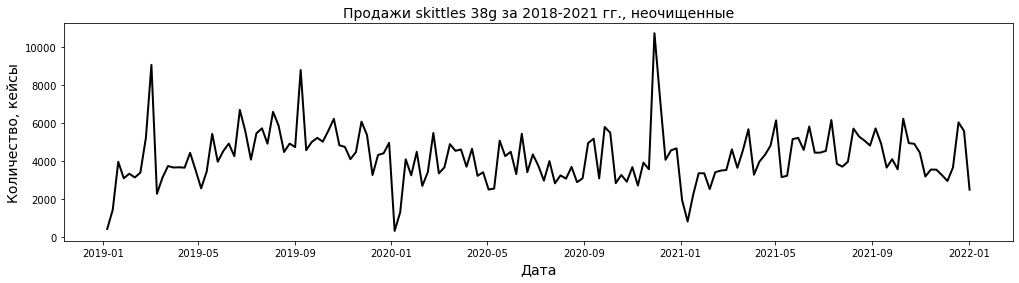

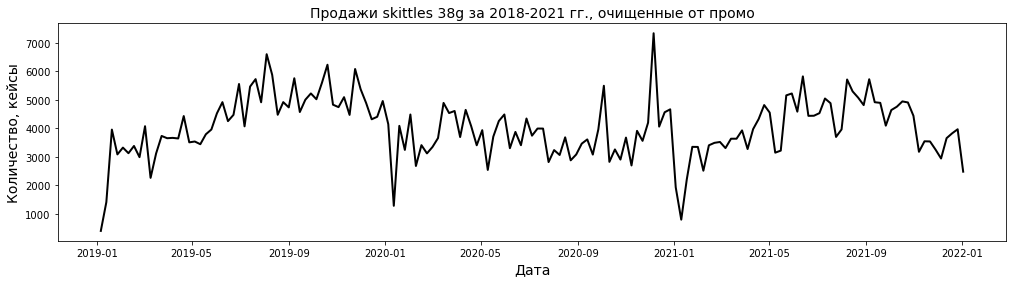

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


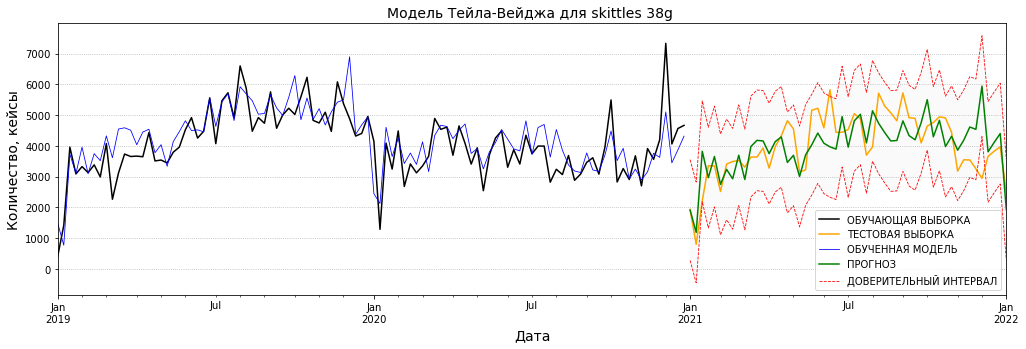

{'smoothing_level': 0.196697723498327,
 'smoothing_trend': 6.068423688919981e-05,
 'smoothing_seasonal': 0.025030926958180266,
 'damping_trend': 0.9480101656989499,
 'initial_level': 3425.9728582802136,
 'initial_trend': 225.52789003451917,
 'initial_seasons': array([-2152.18468503, -2860.57464499,  -222.02123897, -1074.92933952,
         -389.7813403 , -1289.09060981,  -801.59853153, -1105.53179019,
         -334.66016014, -1129.53919959,   -56.03424111,   145.53113386,
          123.17444798,  -288.44661075,    94.98808263,   250.12778769,
         -583.44209612,  -354.98970262, -1041.39362511,  -341.06061022,
          -20.45668357,   362.43842825,    36.65800479,   -87.3222888 ,
         -156.7943842 ,   898.83996548,   -89.62061842,   763.30188315,
          977.68530208,    52.12297634,  1090.85050081,   685.26322973,
          385.53041173,   106.11229967,   119.25647187,   752.27447253,
          276.88527658,   134.17873512,   691.93585708,  1440.96201138,
          228.318870

MSE: 404660.1575
MAPE: 0.1526
MPE: -0.0829


None

MSE: 666221.5491
MAPE: 0.17
MPE: -0.0301


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


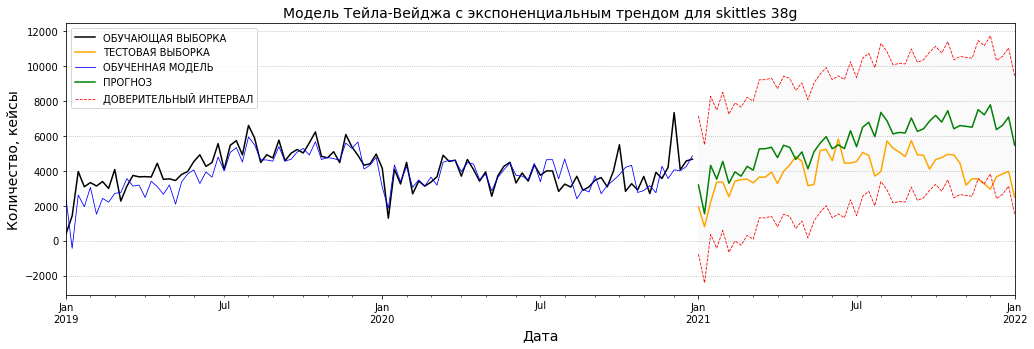

{'smoothing_level': 0.32724999857715886,
 'smoothing_trend': 0.032841643451006014,
 'smoothing_seasonal': 0.091494000251632,
 'damping_trend': 0.9904999999829,
 'initial_level': 3977.263670891953,
 'initial_trend': 0.9157098932349105,
 'initial_seasons': array([-1219.8952774 , -3109.06377962,  -364.3179646 , -1191.99605201,
         -171.30487172, -1538.12753765,  -897.26561588, -1178.22218775,
         -690.42225783,  -851.88078328,   325.23046583,   234.26983371,
          281.24814708,  -403.49069732,   307.00145209,    90.17771394,
         -625.30427462,  -214.40093186, -1273.80015682,  -299.36408559,
          162.36103565,   480.46128411,  -325.41397669,   -76.48988817,
         -364.58939631,   624.62285943,  -312.42431358,   819.31044534,
         1059.55774033,   195.51335426,  1584.64129676,   998.96803074,
           93.58666341,   213.36812413,   120.62613155,   964.57630225,
           80.67866757,   241.93333531,   603.35878505,   820.14672735,
          591.71959846,  1

MSE: 586809.7632
MAPE: 0.1913
MPE: 0.0133


None

MSE: 3884304.47
MAPE: 0.4621
MPE: -0.4586


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


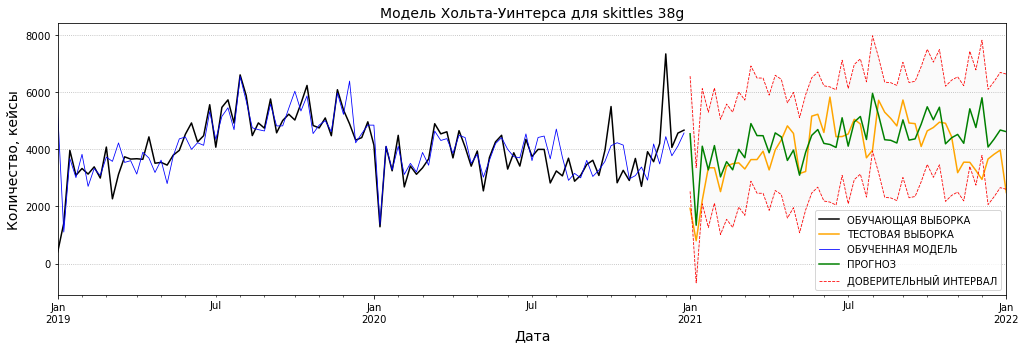

{'smoothing_level': 0.2878571339215375,
 'smoothing_trend': 0.00010000892939718048,
 'smoothing_seasonal': 0.02967264060504549,
 'damping_trend': 0.9900000001552091,
 'initial_level': 4391.296933206649,
 'initial_trend': 4.528017896334589,
 'initial_seasons': array([1.20141979, 0.34161554, 1.04915343, 0.83899396, 1.05729811,
        0.77511315, 0.91161232, 0.83985954, 1.02197214, 0.95422572,
        1.2577788 , 1.13874758, 1.13877888, 0.98484905, 1.16633414,
        1.12495621, 0.9171657 , 1.01069119, 0.78569041, 0.98963065,
        1.14358686, 1.19107844, 1.06709934, 1.05742262, 1.03223192,
        1.29534032, 1.04375685, 1.25858947, 1.30792609, 1.10703633,
        1.52364895, 1.32097364, 1.091471  , 1.09389797, 1.06698726,
        1.27351839, 1.08905536, 1.10468381, 1.23130344, 1.38077785,
        1.28299702, 1.38933479, 1.05767064, 1.10624501, 1.14780592,
        1.05327337, 1.37257577, 1.19333653, 1.44636619, 1.02583746,
        1.09646096, 1.17746188]),
 'use_boxcox': False,
 'lam

MSE: 554450.9954
MAPE: 0.2166
MPE: -0.1285


None

MSE: 1007999.5141
MAPE: 0.2357
MPE: -0.1476


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


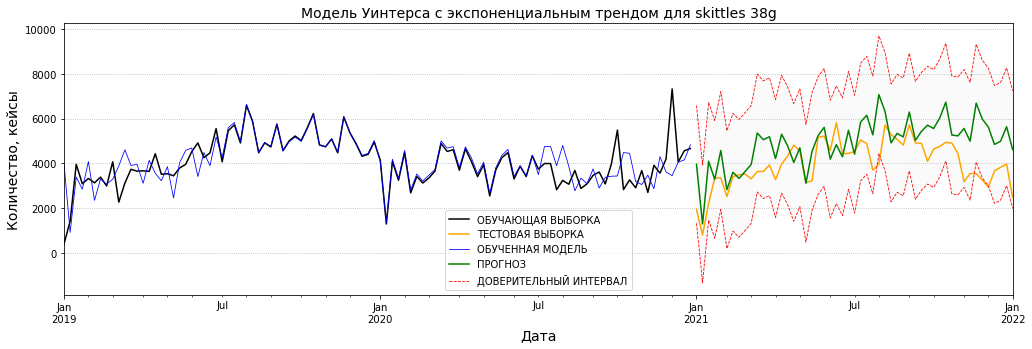

{'smoothing_level': 0.28785714285714287,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.02967261904761905,
 'damping_trend': 0.99,
 'initial_level': 4391.297048948566,
 'initial_trend': 1.0111323087672643,
 'initial_seasons': array([0.89842241, 0.28016532, 0.89580019, 0.7169985 , 1.00300744,
        0.60813414, 0.78012837, 0.71871922, 0.77708775, 0.85741923,
        1.15450558, 1.07815101, 1.10370807, 0.88668712, 1.12127977,
        0.99706691, 0.84379125, 0.9821306 , 0.6399967 , 0.94074518,
        1.0876397 , 1.15730448, 0.84978435, 0.99082596, 0.87205966,
        1.11152053, 0.89350506, 1.18956445, 1.24655162, 1.06921822,
        1.43174311, 1.27263924, 0.97060844, 1.06627388, 1.02776503,
        1.24748118, 0.98425287, 1.07105439, 1.11390292, 1.06843378,
        1.18821272, 1.32087263, 1.02511351, 1.00639957, 1.08151845,
        0.9514796 , 1.29321858, 1.14199814, 1.04219151, 0.92529802,
        0.94683268, 1.07079099]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': F

MSE: 579098.7155
MAPE: 0.1886
MPE: -0.1013


None

MSE: 1725839.3503
MAPE: 0.2994
MPE: -0.2758


None


--------------------------------SARIMA MODEL-----------------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9970      0.005    196.276      0.000       0.987       1.007
ma.L1         -0.6674      0.090     -7.448      0.000      -0.843      -0.492
sigma2       7.47e+05   6.39e+04     11.691      0.000    6.22e+05    8.72e+05
Обучающая выборка
MSE: 762372.4964
MAPE: 0.1837
MPE: 0.0107


None

Тестовая выборка
MSE: 1238801.7221
MAPE: 0.3205
MPE: -0.1932


None

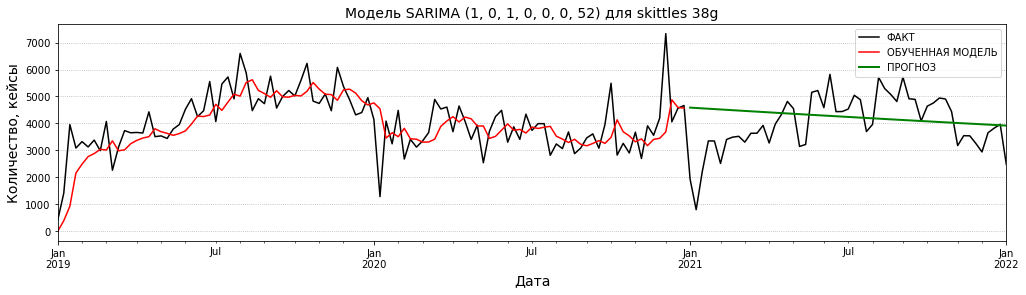

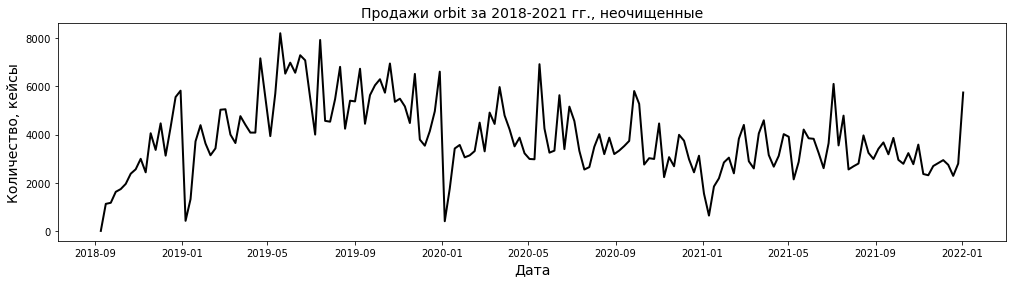

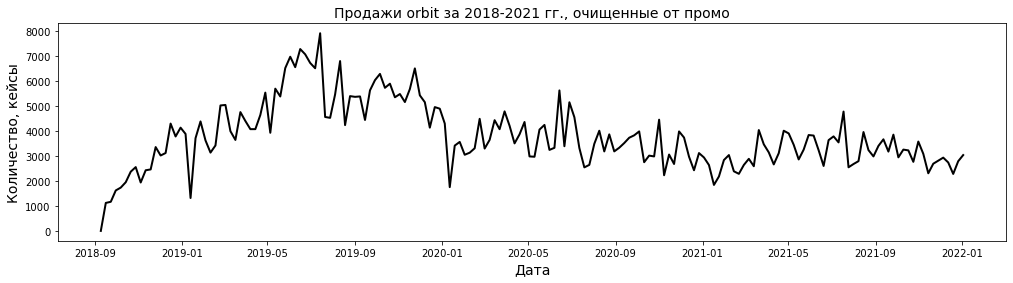

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


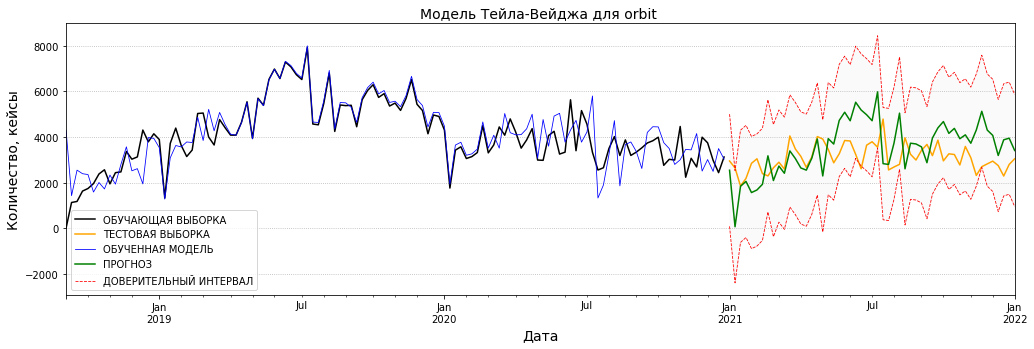

{'smoothing_level': 0.46464285714285714,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.05098639455782313,
 'damping_trend': 0.99,
 'initial_level': 4169.356576676117,
 'initial_trend': 74.43050009613205,
 'initial_seasons': array([   52.91166668,  -893.03816922,   291.14372065,   701.47474421,
          946.58266721,   394.31386892,   571.46084452,    47.56140549,
          197.57029783,   -87.56215168,   472.92193078,  1332.07742969,
          311.83619022,   104.36581694,  -866.55021277,     6.55865201,
           -6.54329007,  -566.66082915, -3046.48722425, -1322.18899041,
        -1137.398014  , -1614.01716292, -1486.12202584, -1271.63835977,
          -68.69370561, -1223.09548732,  -473.03861764,  -906.45440972,
          132.03449283,  -308.86494206,  -721.00374941,  -800.67745872,
         -304.12741287,   529.50619616, -1137.54437099,   565.95854982,
          196.09992192,  1270.25947097,  1671.32898071,  1211.21570851,
         1917.92570127,  1697.48115131,  1333.6881

MSE: 617478.6722
MAPE: 2.542
MPE: -2.4365


None

MSE: 1501570.341
MAPE: 0.3287
MPE: -0.158


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


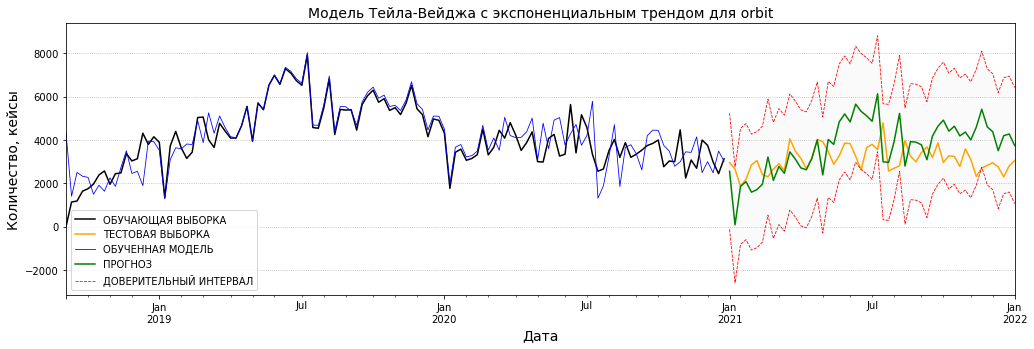

{'smoothing_level': 0.46464285714285714,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.05098639455782313,
 'damping_trend': 0.99,
 'initial_level': 4169.356576676117,
 'initial_trend': 1.0279512214493285,
 'initial_seasons': array([   52.91166668,  -893.03816922,   291.14372065,   701.47474421,
          946.58266721,   394.31386892,   571.46084452,    47.56140549,
          197.57029783,   -87.56215168,   472.92193078,  1332.07742969,
          311.83619022,   104.36581694,  -866.55021277,     6.55865201,
           -6.54329007,  -566.66082915, -3046.48722425, -1322.18899041,
        -1137.398014  , -1614.01716292, -1486.12202584, -1271.63835977,
          -68.69370561, -1223.09548732,  -473.03861764,  -906.45440972,
          132.03449283,  -308.86494206,  -721.00374941,  -800.67745872,
         -304.12741287,   529.50619616, -1137.54437099,   565.95854982,
          196.09992192,  1270.25947097,  1671.32898071,  1211.21570851,
         1917.92570127,  1697.48115131,  1333.688

MSE: 624465.3167
MAPE: 2.5434
MPE: -2.4337


None

MSE: 1781175.0942
MAPE: 0.3647
MPE: -0.2075


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


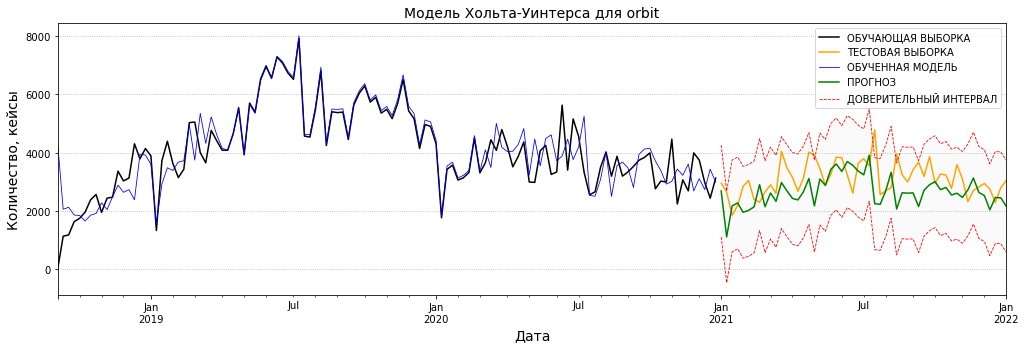

{'smoothing_level': 0.42928571428571427,
 'smoothing_trend': 0.022593984962406014,
 'smoothing_seasonal': 0.0001,
 'damping_trend': 0.99,
 'initial_level': 4169.356576676117,
 'initial_trend': 74.43050009613205,
 'initial_seasons': array([1.01531448, 0.83733341, 1.06005846, 1.13732746, 1.18322887,
        1.07950978, 1.11323056, 1.01462047, 1.04336106, 0.98937745,
        1.09774746, 1.26563394, 1.06871505, 1.02889542, 0.83417489,
        1.01046015, 1.00832675, 0.89265365, 0.37092065, 0.72988171,
        0.76765042, 0.66282713, 0.68772389, 0.7327577 , 0.99847265,
        0.74043176, 0.907648  , 0.81226894, 1.04173045, 0.94562235,
        0.85918046, 0.84442748, 0.94723973, 1.11497428, 0.78209202,
        1.11824788, 1.04472868, 1.24929475, 1.32219234, 1.23273435,
        1.36404015, 1.32209082, 1.25306537, 1.21084544, 1.46862008,
        0.84741219, 0.84276569, 1.01943083, 1.26920806, 0.79197458,
        1.0092987 , 1.00823116]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': F

MSE: 497833.5706
MAPE: 2.5228
MPE: -2.4333


None

MSE: 617664.5551
MAPE: 0.1882
MPE: 0.1223


None

C:\Users\kokanat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


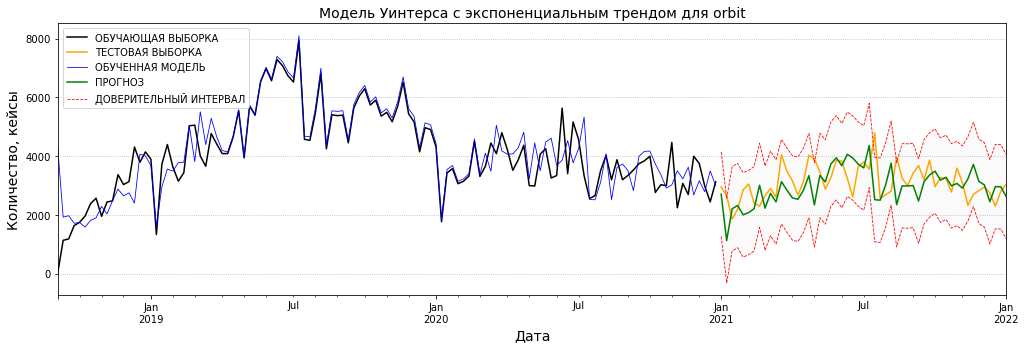

{'smoothing_level': 0.46464285714285714,
 'smoothing_trend': 0.02445488721804511,
 'smoothing_seasonal': 0.00010000000000000002,
 'damping_trend': 0.99,
 'initial_level': 4169.356576676117,
 'initial_trend': 1.0279512214493285,
 'initial_seasons': array([1.01531448, 0.83733341, 1.06005846, 1.13732746, 1.18322887,
        1.07950978, 1.11323056, 1.01462047, 1.04336106, 0.98937745,
        1.09774746, 1.26563394, 1.06871505, 1.02889542, 0.83417489,
        1.01046015, 1.00832675, 0.89265365, 0.37092065, 0.72988171,
        0.76765042, 0.66282713, 0.68772389, 0.7327577 , 0.99847265,
        0.74043176, 0.907648  , 0.81226894, 1.04173045, 0.94562235,
        0.85918046, 0.84442748, 0.94723973, 1.11497428, 0.78209202,
        1.11824788, 1.04472868, 1.24929475, 1.32219234, 1.23273435,
        1.36404015, 1.32209082, 1.25306537, 1.21084544, 1.46862008,
        0.84741219, 0.84276569, 1.01943083, 1.26920806, 0.79197458,
        1.0092987 , 1.00823116]),
 'use_boxcox': False,
 'lamda': None,
 

MSE: 505082.6663
MAPE: 2.523
MPE: -2.4363


None

MSE: 513008.2754
MAPE: 0.1689
MPE: 0.0255


None


--------------------------------SARIMA MODEL-----------------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3959      0.137      2.889      0.004       0.127       0.664
ar.L2          0.2219      0.138      1.604      0.109      -0.049       0.493
ar.L3          0.2914      0.103      2.827      0.005       0.089       0.493
sigma2      8.249e+05    1.4e+05      5.875      0.000     5.5e+05     1.1e+06
Обучающая выборка
MSE: 1102419.5836
MAPE: 0.2465
MPE: 0.0506


None

Тестовая выборка
MSE: 767407.4518
MAPE: 0.2038
MPE: 0.0458


None

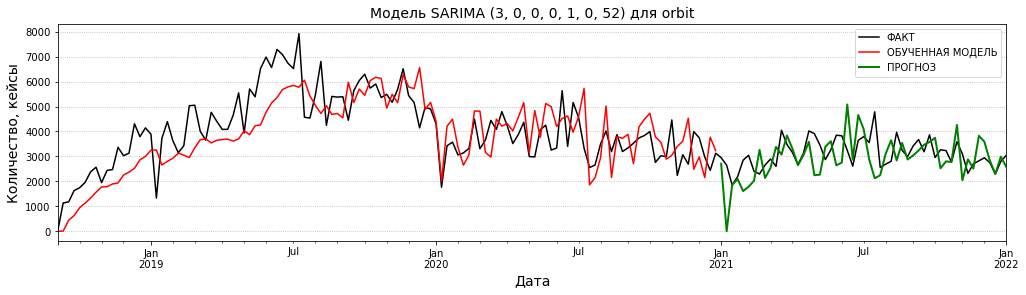

In [6]:
total_models('snickers', '2018-01-01', 0.1, 8, False, 1,1,1,0,0,0,52)
total_models('skittles 38g', '2019-01-01', 0.1, 8, True, 1,0,1,0,0,0,52)
total_models('orbit', '2018-09-09', 0.1, 8, True, 3,0,0,0,1,0,52)

### Определение параметров модели SARIMA

функция чистит данные, и применяет функцию auto_arima для определения оптимальных параметров

In [7]:
def sarima_detect(file_name, date_cut, annomaly_share, window, train_dur, S):    
    
    #чистка данных
    df = pd.read_excel(file_name+'.xlsx', parse_dates=['date'])
    df=df[df['date']>=date_cut]
    df=df.set_index('date')
    df=df.resample('W').sum()
    df=df.dropna()
    
    rolling_mean = df['qty'].rolling(window=window).mean()

    t_crit=scs.t.ppf(1-annomaly_share, df.shape[0]) #t критерий стьюдента 2хстороний
    rolling_std =  df['qty'].rolling(window=window).std()
    upper_bond = rolling_mean+t_crit*rolling_std
    lower_bond = rolling_mean-t_crit*rolling_std

    df['up']=upper_bond
    df['low']=lower_bond
    df['rolling']=rolling_mean

    df.loc[(df['qty']>df['up'])|(df['qty']<df['low'])|(df['qty']<=5), 'qty']=df['rolling']
    df=df.drop(columns=['up','low', 'rolling'], axis=1)
    df=df.fillna(0)
    
    #определяем SARIMA
    train, test = df[:train_dur], df[train_dur:]
    print(f'--------------------SARIMA для {file_name}-----------------------')
    sarima=pm.auto_arima(train, seasonal=True, m=S, trace=True, 
                         suppress_warnings=True, error_actions='ignore', 
                         stepwise=True, trend='t') 

In [8]:
sarima_detect('snickers', '2018-01-01', 0.01, 8, '2021-01-01', 52)
sarima_detect('skittles 38g', '2019-01-01', 0.1, 8, '2021-01-01', 52)
sarima_detect('orbit', '2018-09-09', 0.1, 8, '2021-01-01', 52)

--------------------SARIMA для snickers-----------------------
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=6.73 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3239.643, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3222.758, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3214.333, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3239.643, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=3225.519, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=3215.708, Time=2.16 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=3215.939, Time=7.58 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=3213.716, Time=1.36 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=3215.715, Time=7.63 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=26.52 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=3233.632, Time=1.00 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=3209.005, Time=2.50 sec
 ARIMA(1,1,1)(0,0,0)[52] interce